# RAG Systems Evaluation

In [2]:
!pip install -q transformers torch accelerate

In [4]:
NEO4J_URI = "neo4j+s://0c367113.databases.neo4j.io"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "gTO1K567hBLzkRdUAhhEb-UqvBjz0i3ckV3M9v_-Nio"
model_name = "Qwen/Qwen2.5-14B-Instruct"

## Load Model

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

print("Loading Qwen2.5-14B-Instruct model from Hugging Face...")

device = "cuda" if torch.cuda.is_available() else "cpu"


print(f"Downloading from Hugging Face Hub: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None,
    trust_remote_code=True
)

if device == "cpu":
    model = model.to(device)

model.eval()
print(f"Model loaded successfully from Hugging Face on {device}")

Loading Qwen2.5-14B-Instruct model from Hugging Face...


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model loaded successfully from Hugging Face on cuda


## Evaluation Function

In [7]:
def evaluate_answer(question, ground_truth, generated_answer):

    evaluation_prompts = [
        # Prompt 1: Đánh giá độ chính xác
        f"""Bạn là chuyên gia lịch sử. Đánh giá độ chính xác của Result so với Answer cho câu hỏi sau. Cho điểm từ 0-10.

Câu hỏi: {question}
Answer (chuẩn): {ground_truth}
Result (cần đánh giá): {generated_answer}

Trả lời CHỈ MỘT SỐ từ 0 đến 10.""",
        
        # Prompt 2: Đánh giá độ đầy đủ
        f"""Bạn là chuyên gia đánh giá. Đánh giá xem Result có đầy đủ thông tin như Answer không cho câu hỏi sau. Cho điểm từ 0-10.

Câu hỏi: {question}
Answer (chuẩn): {ground_truth}
Result (cần đánh giá): {generated_answer}

Trả lời CHỈ MỘT SỐ từ 0 đến 10.""",
        
        # Prompt 3: Đánh giá độ liên quan
        f"""Bạn là chuyên gia đánh giá. Đánh giá xem Result có trả lời đúng trọng tâm câu hỏi như Answer không. Cho điểm từ 0-10.

Câu hỏi: {question}
Answer (chuẩn): {ground_truth}
Result (cần đánh giá): {generated_answer}

Trả lời CHỈ MỘT SỐ từ 0 đến 10.""",
        
        # Prompt 4: Đánh giá tổng thể (thứ tự đảo)
        f"""Bạn là chuyên gia đánh giá. So sánh chất lượng của Result với Answer. Cho điểm từ 0-10.

Câu hỏi: {question}
Result (cần đánh giá): {generated_answer}
Answer (chuẩn): {ground_truth}

Trả lời CHỈ MỘT SỐ từ 0 đến 10.""",
        
        # Prompt 5: Đánh giá tổng thể
        f"""Bạn là chuyên gia đánh giá. So sánh chất lượng của Result với Answer. Cho điểm từ 0-10.

Câu hỏi: {question}
Answer (chuẩn): {ground_truth}
Result (cần đánh giá): {generated_answer}

Trả lời CHỈ MỘT SỐ từ 0 đến 10."""
    ]
    
    def get_score(prompt):
        messages = [
            {"role": "system", "content": "Bạn là chuyên gia đánh giá. Trả lời ngắn gọn chỉ một con số."},
            {"role": "user", "content": prompt}
        ]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=10,
                temperature=0.1,
                do_sample=False
            )
        
        generated_ids = [
            output_ids[len(input_ids):]
            for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        
        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # Extract số
        import re
        numbers = re.findall(r'\d+\.?\d*', response)
        if numbers:
            score = float(numbers[0])
            return min(max(score, 0), 10)  # Clamp giữa 0-10
        return 5.0
    
    # Đánh giá với tất cả các prompts
    scores = [get_score(prompt) for prompt in evaluation_prompts]
    
    # Tính trung bình và độ lệch chuẩn
    import numpy as np
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    
    return avg_score, std_score


## Load Test Data

In [9]:
import glob
test_files = sorted(glob.glob("data/test/test*.json"))
for f in test_files:
    print(f"  - {f}")
test_data = []
for test_file in test_files:
    with open(test_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        test_data.extend(data)
        print(f"Loaded {len(data)} questions from {test_file}")

  - data/test/test1.json
  - data/test/test2.json
  - data/test/test3.json
  - data/test/test4.json
  - data/test/test5.json
Loaded 20 questions from data/test/test1.json
Loaded 20 questions from data/test/test2.json
Loaded 20 questions from data/test/test3.json
Loaded 20 questions from data/test/test4.json
Loaded 20 questions from data/test/test5.json


## Initialize RAG Systems

In [11]:
# Traditional RAG
try:
    from traditional_rag_gemini import TraditionalGeminiRAG
    traditional_rag = TraditionalGeminiRAG()
    print("Traditional RAG ready")
except Exception as e:
    print(f"Error: {e}")
    traditional_rag = None

# Graph RAG
try:
    from graph_rag_gemini import GeminiRAG
    from graph_rag_hybrid import HybridRetriever
    from graph_rag_context import ContextBuilder
    
    hybrid_retriever = HybridRetriever()
    context_builder = ContextBuilder()
    graph_rag = GeminiRAG(hybrid_retriever=hybrid_retriever, context_builder=context_builder)
except Exception as e:
    print(f"Error: {e}")
    graph_rag = None

# Router System
try:
    from router import IntelligentRAGRouter
    router_system = IntelligentRAGRouter()
except Exception as e:
    print(f"Error: {e}")
    router_system = None

Traditional RAG ready
Graph RAG ready
Router System ready


## Run Evaluation

In [ ]:
def evaluate_system(rag_system, system_name, test_data):
    if rag_system is None:
        return None, None
    print(f"Evaluating {system_name}")
    
    scores = []
    stds = []
    
    for item in tqdm(test_data, desc=system_name):
        question = item['question']
        ground_truth = item['answer']
        
        try:
            response = rag_system.query(question)
            
            if isinstance(response, dict):
                generated_answer = response.get('answer', response.get('response', ''))
            else:
                generated_answer = str(response)
            
            # Đánh giá với nhiều prompts
            avg_score, std_score = evaluate_answer(question, ground_truth, generated_answer)
            scores.append(avg_score)
            stds.append(std_score)
            
        except Exception as e:
            print(f"\nError: {e}")
            scores.append(0.0)
            stds.append(0.0)
    
    avg_score = sum(scores) / len(scores) if scores else 0
    avg_std = sum(stds) / len(stds) if stds else 0
    
    print(f"\n{system_name} Average Score: {avg_score:.2f}/10 (±{avg_std:.2f})")
    
    return avg_score, avg_std


results = {}
std_devs = {}

if traditional_rag:
    avg, std = evaluate_system(traditional_rag, 'Traditional RAG', test_data)
    results['Traditional RAG'] = avg
    std_devs['Traditional RAG'] = std

if graph_rag:
    avg, std = evaluate_system(graph_rag, 'Graph RAG', test_data)
    results['Graph RAG'] = avg
    std_devs['Graph RAG'] = std

if router_system:
    avg, std = evaluate_system(router_system, 'Hybrid System', test_data)
    results['Hybrid System'] = avg
    std_devs['Hybrid System'] = std

Evaluating Traditional RAG


Traditional RAG: 100%|██████████| 100/100 [2:15:34<00:00, 81.34s/it]



Traditional RAG Average Score: 5.02/10 (±1.45)
Evaluating Graph RAG


Graph RAG: 100%|██████████| 100/100 [4:23:18<00:00, 157.98s/it]



Graph RAG Average Score: 6.14/10 (±1.23)
Evaluating Hybrid System


Hybrid System: 100%|██████████| 100/100 [4:05:47<00:00, 147.47s/it]



Hybrid System Average Score: 6.73/10 (±1.08)


## Results - Bar Chart

Traditional RAG     : 5.02/10 (±1.45)
Graph RAG           : 6.14/10 (±1.23)
Hybrid System       : 6.73/10 (±1.08)


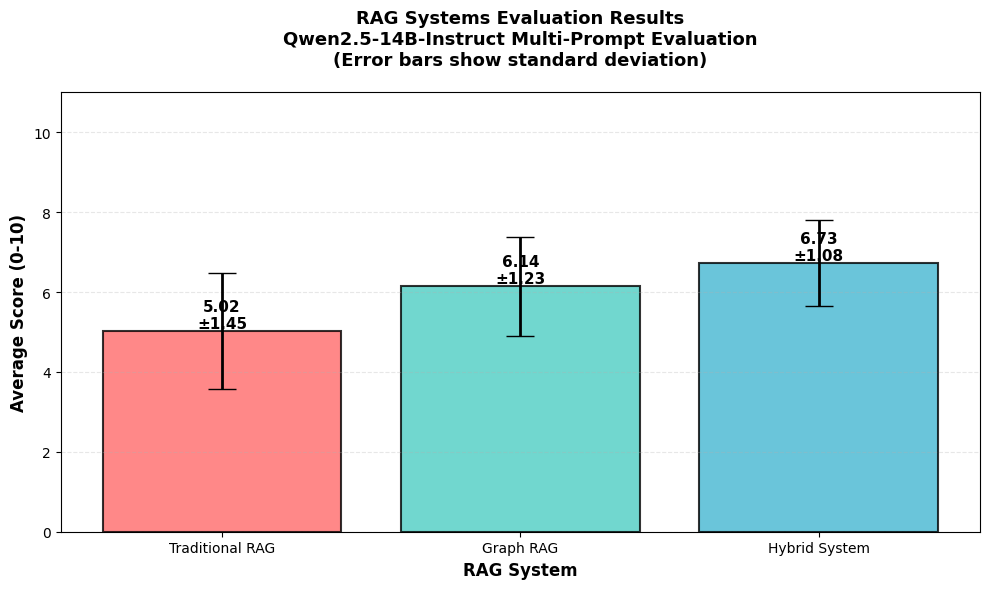

In [ ]:
import numpy as np

df_results = pd.DataFrame([
    {'System': system, 'Score': score, 'Std': std_devs.get(system, 0)}
    for system, score in results.items()
])

plt.figure(figsize=(10, 6))

# Vẽ bar chart với error bars
bars = plt.bar(df_results['System'], df_results['Score'],
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
               alpha=0.8, edgecolor='black', linewidth=1.5,
               yerr=df_results['Std'], capsize=10, error_kw={'linewidth': 2})

# Add value labels trên bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    std = df_results.iloc[i]['Std']
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}\n±{std:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('RAG System', fontsize=12, fontweight='bold')
plt.ylabel('Average Score', fontsize=12, fontweight='bold')
plt.title('RAG Systems Evaluation Results\nQwen2.5-14B-Instruct Multi-Prompt Evaluation\n(Error bars show standard deviation)',
          fontsize=13, fontweight='bold', pad=20)
plt.ylim(0, 11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()